# LoL Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Some player entries are missing their teamPosition
# Fix this by filling missing position with the only remaining role

df = pd.read_csv('matches_data.csv')
df['teamPosition'] = df['teamPosition'].replace({'UTILITY':'SUPPORT'})

all_roles = ['TOP', 'JUNGLE', 'MIDDLE', 'BOTTOM', 'SUPPORT']

def fill_missing_teamPos(df: pd.DataFrame):
    games_with_null_pos = df.loc[~df['teamPosition'].isin(all_roles), ['matchId', 'summonerId', 'teamId']]
    
    for index, row in games_with_null_pos.iterrows():
        game = df[df['matchId'] == row['matchId']]
        set_of_team_pos = set(game.loc[game['teamId']==row['teamId'], 'teamPosition'])
        missing_pos = (set(all_roles) - set_of_team_pos).pop()
        row_test = row
        df.loc[(df['matchId']==row['matchId']) & (df['summonerId']==row['summonerId']), 'teamPosition'] = missing_pos

    return df

df = fill_missing_teamPos(df)

In [32]:
key_word = ''
for index, column in enumerate(df.columns):
    if key_word in column:
        print(f'{index:3} : {column}')

  0 : matchId
  1 : summonerId
  2 : championName
  3 : teamId
  4 : teamPosition
  5 : kills
  6 : assists
  7 : deaths
  8 : goldEarned
  9 : baronKills
 10 : bountyLevel
 11 : champExperience
 12 : champLevel
 13 : championId
 14 : championTransform
 15 : consumablesPurchased
 16 : damageDealtToBuildings
 17 : damageDealtToObjectives
 18 : damageDealtToTurrets
 19 : damageSelfMitigated
 20 : detectorWardsPlaced
 21 : doubleKills
 22 : dragonKills
 23 : firstBloodAssist
 24 : firstBloodKill
 25 : firstTowerAssist
 26 : firstTowerKill
 27 : gameEndedInEarlySurrender
 28 : gameEndedInSurrender
 29 : goldSpent
 30 : individualPosition
 31 : inhibitorKills
 32 : inhibitorTakedowns
 33 : inhibitorsLost
 34 : item0
 35 : item1
 36 : item2
 37 : item3
 38 : item4
 39 : item5
 40 : item6
 41 : itemsPurchased
 42 : killingSprees
 43 : lane
 44 : largestCriticalStrike
 45 : largestKillingSpree
 46 : largestMultiKill
 47 : longestTimeSpentLiving
 48 : magicDamageDealt
 49 : magicDamageDealtToCh

## 1. Match Duration

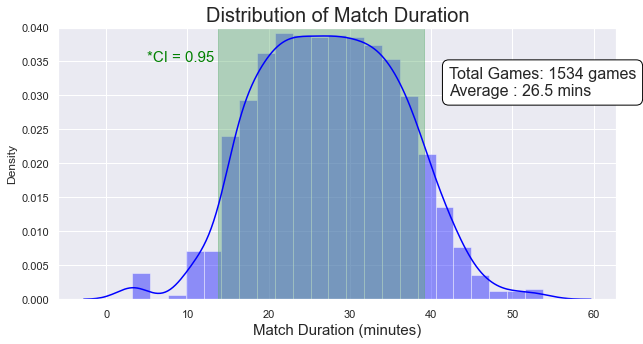

In [76]:
from scipy.stats import norm
games_count = len(df['game_duration'].unique()) 

sns.set_theme()
plt.figure(figsize=(10,5))
g = sns.distplot(df['game_duration'].unique()/60, color='blue', fit=None)
((x0, y0), (x1, y1)) = g.patches[int(len(g.patches)/1.5)].get_bbox().get_points()
ci = norm(*norm.fit(df['game_duration']/60)).interval(0.95)

plt.title('Distribution of Match Duration', fontsize=20)
plt.xlabel('Match Duration (minutes)', fontsize=15)
plt.text(x1*1.1, y1, f'Total Games: {games_count} games\nAverage : {np.mean(df.game_duration)/60:.1f} mins', fontsize=16,
         bbox=dict(boxstyle="round, pad=0.4", fc="white", ec="black", lw=1))
plt.text(5, 0.035, '*CI = 0.95', fontsize=15, color='green')
plt.ylim(0, 0.04)
x=plt.fill_betweenx([0, 0.04], ci[0], ci[1], color='g', alpha=0.4)
plt.show()

The majority of games played by challenger players is around 20-30 minutes which is around 10 minutes shorter than DOTA2 average match time. A number of matched with match duration under 5 minutes can be observed; these matches are probably matches where a player is disconnected and the team decided to surrender early right away.

## 2. Champion Popularity and Win Rate

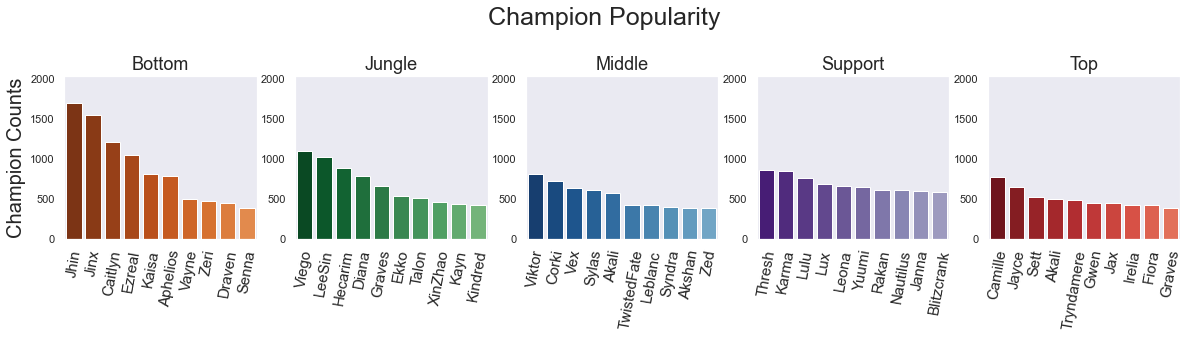

In [120]:
# Plot champion popularity by roles

data = df.groupby(['teamPosition', 'championName'])['matchId'].count()
data = data.reset_index().groupby('teamPosition')[['championName','matchId']].apply(lambda x: x.nlargest(10, 'matchId'))

palette = {'BOTTOM': sns.color_palette("Oranges_r", 20),
           'JUNGLE': sns.color_palette("Greens_r", 20),
           'MIDDLE': sns.color_palette("Blues_r", 20),
           'SUPPORT': sns.color_palette("Purples_r", 20),
           'TOP': sns.color_palette("Reds_r", 20)}


fig, ax = plt.subplots(1,5, figsize=(20,3))
sns.set_style('dark')
for index, role in enumerate(data.index.get_level_values(0).drop_duplicates()):
    sns.barplot(x=data.loc[role]['championName'],
                y=data.loc[role]['matchId'],
                ax=ax[index],
                palette=palette[role]
               )
    ax[index].tick_params(axis='x', rotation=80, labelsize=15)
    ax[index].set_ylabel('')
    ax[index].set_xlabel('', )
    ax[index].set_ylim(0, data['matchId'].max()*1.2)
    ax[index].set_title(role.capitalize(), loc='center', fontsize=18)
    
ax[0].set_ylabel('Champion Counts', size=20)
fig.suptitle('Champion Popularity', fontsize=25, **{'y':1.2})
plt.show()

## 3. Average Stats by Roles

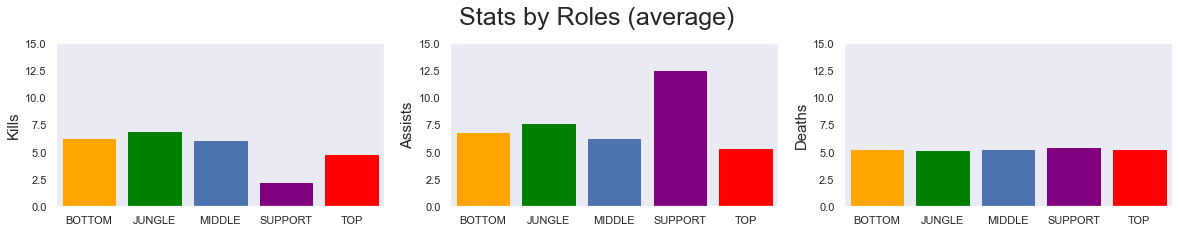

In [161]:
fig, ax = plt.subplots(1,3, figsize=(20,3))
sns.set_style('dark')

palette = {0: 'orange',
           1: 'green',
           2: 'b',
           3: 'purple',
           4: 'red'}

attributes = ['kills', 'assists', 'deaths']
for index, attribute in enumerate(attributes):
    bar_ax = sns.barplot(x='teamPosition',
                     y=attribute,
                     data=df,
                     estimator=np.mean,
                     ax=ax[index],
                     ci=None, order=['BOTTOM', 'JUNGLE', 'MIDDLE', 'SUPPORT', 'TOP'])
    for color_index, bar in enumerate(bar_ax.patches):
        bar.set_color(palette[color_index])
    
    ax[index].set_ylabel(attribute.capitalize(), fontsize=15)
    ax[index].set_xlabel('')
    ax[index].set_ylim(0, 15)

fig.suptitle('Stats by Roles (average)', fontsize=25, **{'y':1.05})
plt.show()

## 4. Do Popular Champions Win More Frequently?

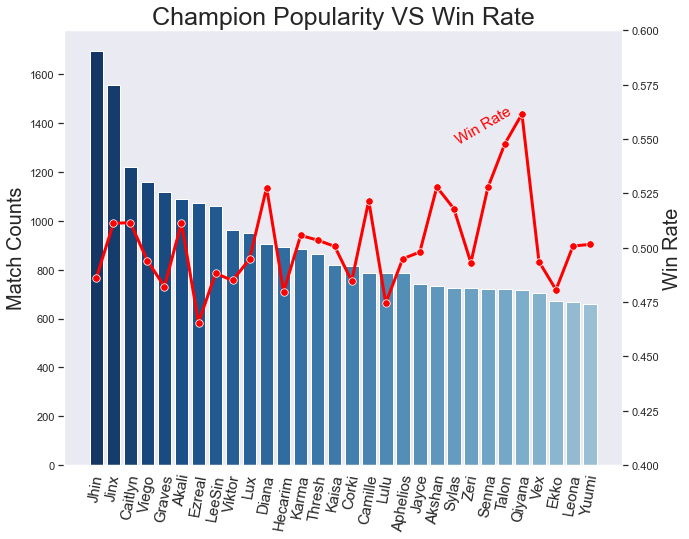

In [360]:
sns.set_style('dark')

win_rate_by_champ = df.pivot_table(index='championName',
                                   columns='win',
                                   values='matchId',
                                   aggfunc='count').rename(columns={False: 'loss', True: 'win'})
win_rate_by_champ['total_matches'] = win_rate_by_champ['win'] + win_rate_by_champ['loss']
win_rate_by_champ['win_rate'] = win_rate_by_champ['win'] / win_rate_by_champ['total_matches']
win_rate_by_champ.sort_values(by='win_rate', ascending=False, inplace=True)

plt.subplots(figsize=(10,8))

sort_by_matches_played = win_rate_by_champ.nlargest(30, 'total_matches')
ax1 = sns.barplot(x=sort_by_matches_played.index,
                  y=sort_by_matches_played['total_matches'],
                  palette=sns.color_palette("Blues_r", 50))
ax1.set_xlabel('')
ax1.set_ylabel('Match Counts', size=20)
ax1.tick_params(axis='x', rotation=80, size=4, labelsize=15)


ax2 = ax1.twinx()
sns.lineplot(x=sort_by_matches_played.index,
             y=sort_by_matches_played['win_rate'],
             marker='.',
             color='red',
             lw=3,
             ms=15,
             ax=ax2)

ax2.set_xlabel('')
ax2.set_ylabel('Win Rate', size=20)
ax2.text(sort_by_matches_played.index[-9], sort_by_matches_played['win_rate'][-6], 'Win Rate', color='red', size=15, rotation=30)
ax2.set_ylim(0.4,0.6)


plt.title('Champion Popularity VS Win Rate', size=25)


plt.show()

## 5. First Blood Rate by Champions & Roles

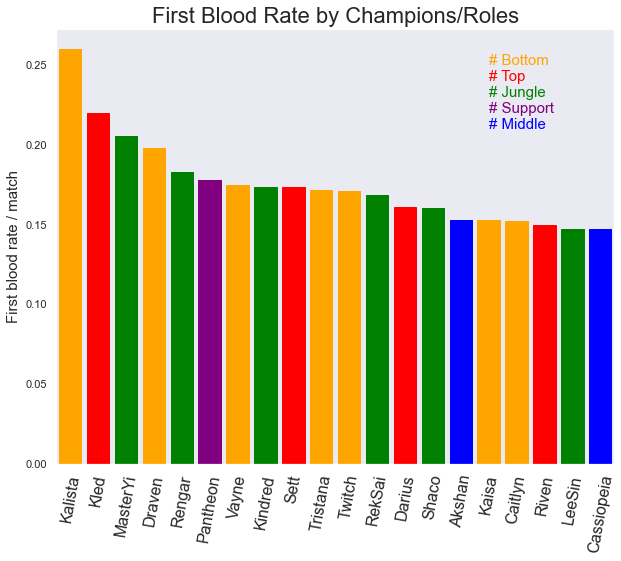

In [503]:
fb_rate = df.groupby(by='championName')['firstBloodKill'].sum()
champion_roles = df.pivot_table(index='championName', values='teamPosition', aggfunc=lambda x: x.value_counts().index[0])
fb_rate = win_rate_by_champ[['total_matches']].join(fb_rate).join(champion_roles)
fb_rate['fb_rate'] = fb_rate['firstBloodKill'] / fb_rate['total_matches']
fb_rate_top20 = fb_rate.sort_values(by='fb_rate', ascending=False).nlargest(20, 'fb_rate')

palette = {'BOTTOM': 'orange',
           'JUNGLE': 'green',
           'MIDDLE': 'blue',
           'SUPPORT': 'purple',
           'TOP': 'red'}

fig, ax = plt.subplots(figsize=(10,8))
bar_ax = sns.barplot(data=fb_rate_top20, x=fb_rate_top20.index, y=fb_rate_top20['fb_rate'], ax=ax)
for index, bar in enumerate(bar_ax.patches):
    bar.set_color(palette[fb_rate_top20.iloc[index]['teamPosition']])
ax.tick_params(axis='x', rotation=80, labelsize=16)
ax.set_xlabel('')
ax.set_ylabel('First blood rate / match', size=15)
plt.text(15, 0.25,'# Bottom', color='orange', size=15)
plt.text(15, 0.24,'# Top', color='red', size=15)
plt.text(15, 0.23,'# Jungle', color='green', size=15)
plt.text(15, 0.22,'# Support', color='purple', size=15)
plt.text(15, 0.21,'# Middle', color='blue', size=15)
plt.title('First Blood Rate by Champions/Roles', size=22)

plt.show()